In [2]:
!pip install gdown

In [3]:
import gdown
import zipfile

# File ID and URL
file_id = "1Kf6dCn1u5Qu9ijt0yltd9tzXI7Dd06W0"
url = "https://drive.google.com/file/d/1f5pAbU5OdnxMPZxIebUFvJeroOXxbWEZ/view?usp=drive_link"
output = "sketches_png.zip"

# Download zip file
gdown.download(url, output, fuzzy=True)

# Extract zip into 'outlier_DATA' folder
with zipfile.ZipFile(output, "r") as zip_ref:
    zip_ref.extractall("sketches")

Downloading...
From (original): https://drive.google.com/uc?id=1f5pAbU5OdnxMPZxIebUFvJeroOXxbWEZ
From (redirected): https://drive.google.com/uc?id=1f5pAbU5OdnxMPZxIebUFvJeroOXxbWEZ&confirm=t&uuid=01174ba3-3375-4d05-a07d-cb18380aeb83
To: /content/sketches_png.zip
100%|██████████| 550M/550M [00:06<00:00, 84.3MB/s]


In [4]:
import os

# Check if dataset folders extracted correctly
print("Folders found:")
for folder in os.listdir("sketches"):
    print(folder)

Folders found:
png


In [5]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

root_dir = "sketches/png"
output_size = (128, 128)

X = []
y = []
class_labels = {}

for label_idx, class_name in enumerate(os.listdir(root_dir)):
    class_path = os.path.join(root_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    class_labels[label_idx] = class_name

    for img_file in os.listdir(class_path):
        if img_file.endswith(".png"):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, output_size)
            img_normalized = img_resized / 255.0

            X.append(img_normalized)
            y.append(label_idx)

X = np.array(X)
y = np.array(y)

# Shuffle the data before plotting
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)


 Code to Show First Few Training Images:

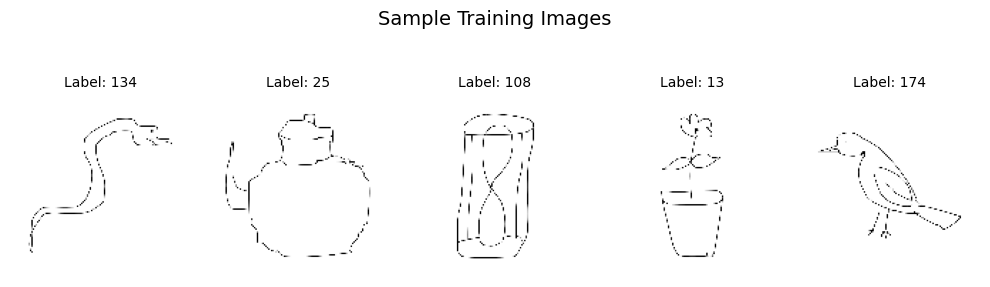

In [6]:
import matplotlib.pyplot as plt

# Plot first 5 training images
plt.figure(figsize=(10, 3))  # height thoda badha diya

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.title(f"Label: {y[i]}", fontsize=10)
    plt.axis('off')

plt.suptitle("Sample Training Images", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave space for suptitle
plt.show()

In [7]:
import cv2
import numpy as np

# 1. Denoising
def denoise_image(image):
    return cv2.fastNlMeansDenoising((image * 255).astype(np.uint8), None, h=10, templateWindowSize=7, searchWindowSize=21) / 255.0

# 2. Contrast Enhancement using Histogram Equalization
def enhance_contrast(image):
    image_uint8 = (image * 255).astype(np.uint8)
    return cv2.equalizeHist(image_uint8) / 255.0

# 3. Apply a Filter (e.g., Sharpening)
def apply_filter(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

# Apply all steps to X
X_preprocessed = []
for img in X:
    denoised = denoise_image(img)
    enhanced = enhance_contrast(denoised)
    filtered = apply_filter(enhanced)
    X_preprocessed.append(filtered)

X_preprocessed = np.array(X_preprocessed)


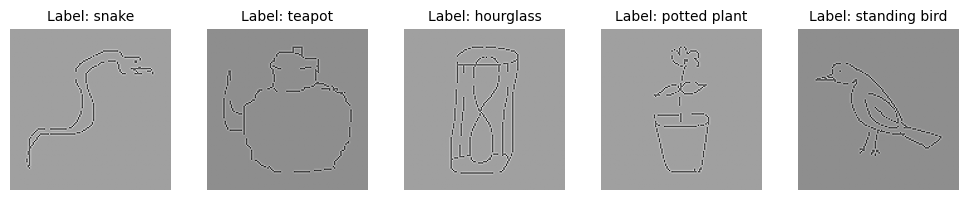

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_preprocessed[i], cmap='gray')
    label = class_labels[y[i]]
    plt.title(f"Label: {label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
def horizontal_projection(im):
    img = (1.0 - im) * 255  # Invert normalized grayscale
    proj = np.sum(img, axis=1)
    m = np.max(proj)
    w = 128  # Match your resized size
    result = np.zeros((img.shape[0], 128))
    for row in range(img.shape[0]):
        if m != 0:
            cv2.line(result, (0, row), (int(proj[row] * w / m), row), (255), 1)
    return result

# Apply to all preprocessed images
hp_x = []
for img in X_preprocessed:
    x = horizontal_projection(img)
    hp_x.append(x)

hp_x = np.array(hp_x).reshape(-1, 128 * 128)

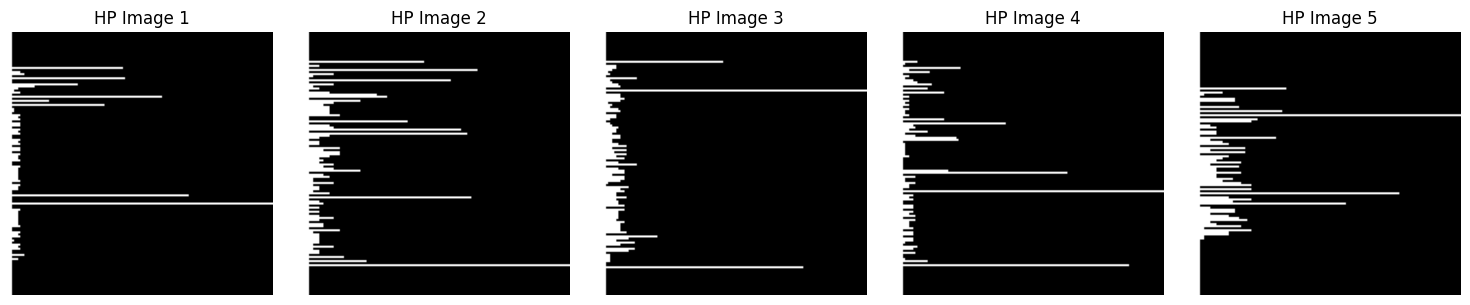

In [10]:
import matplotlib.pyplot as plt

# Reshape back for visualization
hp_images = hp_x.reshape(-1, 128, 128)

# Plot first five projection images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(hp_images[i], cmap='gray')
    plt.title(f"HP Image {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [11]:
import numpy as np
from skimage import measure, filters, color
from skimage.transform import resize
from skimage.feature import canny
from skimage.io import imread

def detect_shapes_skimage(img):
    # Resize image
    img_resized = resize(img, (28, 28), anti_aliasing=True)

    # Convert to grayscale if it's RGB
    if img_resized.ndim == 3:
        img_gray = color.rgb2gray(img_resized)
    else:
        img_gray = img_resized

    # Edge detection using Canny
    edges = canny(img_gray, sigma=1.0)

    # Find contours using skimage
    contours = measure.find_contours(edges, level=0.8)

    features = []

    for contour in contours:
        if len(contour) < 5:
            continue

        # Approximate area and perimeter
        x = contour[:, 1]
        y = contour[:, 0]
        area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
        perimeter = np.sum(np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1)))

        if perimeter == 0:
            continue

        circularity = 4 * np.pi * (area / (perimeter ** 2))
        features.append(circularity)

    return features

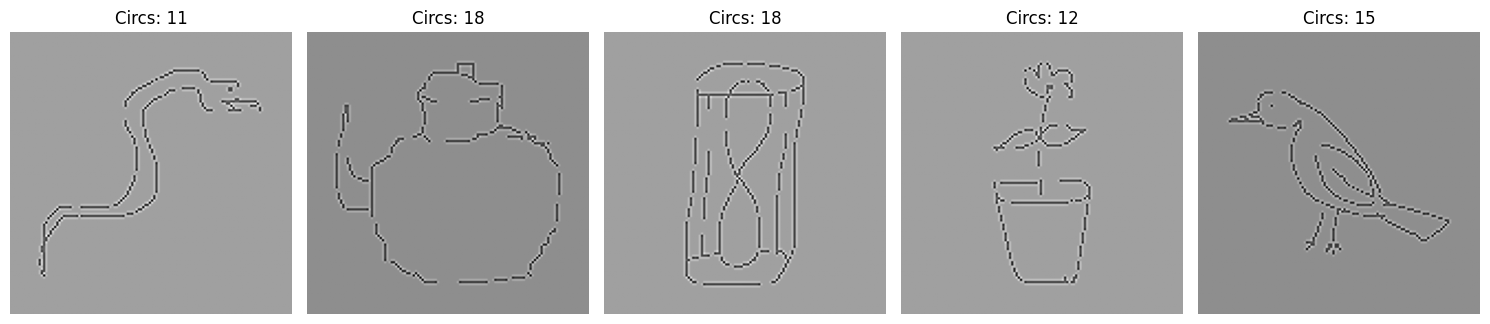

In [12]:
import matplotlib.pyplot as plt

# Plot 5 images and their detected shape features
plt.figure(figsize=(15, 5))

for i in range(5):
    img = X_preprocessed[i]
    features = detect_shapes_skimage(img)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Circs: {len(features)}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
def extract_corners(image):
    image_uint8 = (image * 255).astype(np.uint8)

    corners = cv2.goodFeaturesToTrack(image_uint8, maxCorners=50, qualityLevel=0.01, minDistance=10)
    result = np.copy(image_uint8)
    if corners is not None:
        # Use numpy.int64 (or simply int) instead of numpy.int0
        corners = np.int64(corners)
        for i in corners:
            x, y = i.ravel()
            cv2.circle(result, (x, y), 3, 255, -1)
    return result

# Apply to all preprocessed images
corner_x = []
for img in X_preprocessed:
    corners = extract_corners(img)
    corner_x.append(corners)

corner_x = np.array(corner_x).reshape(-1, 128 * 128)

In [14]:
def detect_edges(image):
    image_uint8 = (image * 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(image_uint8, (3, 3), 0)
    edges = cv2.Canny(blurred, threshold1=30, threshold2=100)
    return edges

# Apply to all preprocessed images
edge_x = []
for img in X_preprocessed:
    edges = detect_edges(img)
    edge_x.append(edges)

edge_x = np.array(edge_x).reshape(-1, 128 * 128)

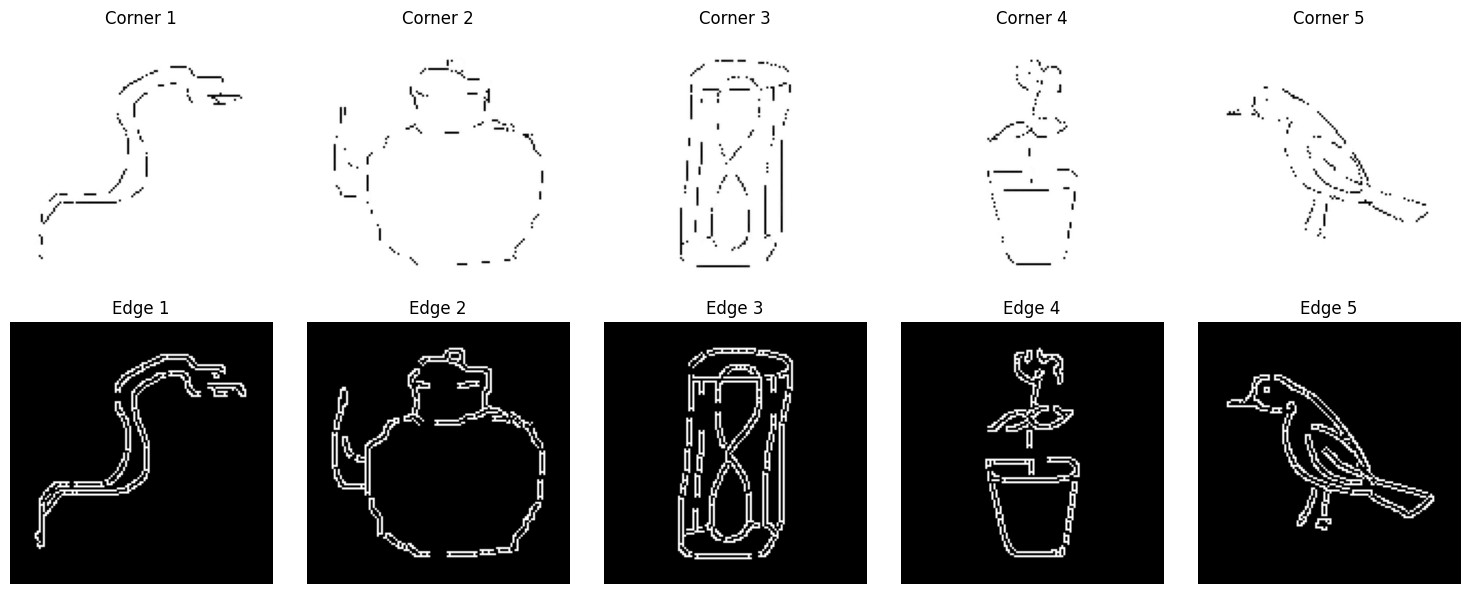

In [15]:
import matplotlib.pyplot as plt

# Reshape for visualization
corner_images = corner_x.reshape(-1, 128, 128)
edge_images = edge_x.reshape(-1, 128, 128)

plt.figure(figsize=(15, 6))

for i in range(5):
    # Corner detection
    plt.subplot(2, 5, i + 1)
    plt.imshow(corner_images[i], cmap='gray')
    plt.title(f"Corner {i+1}")
    plt.axis('off')

    # Edge detection
    plt.subplot(2, 5, i + 6)
    plt.imshow(edge_images[i], cmap='gray')
    plt.title(f"Edge {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
from skimage.feature import local_binary_pattern

def create_lbp_fast(image):
    gray = (image * 255).astype(np.uint8)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp = cv2.normalize(lbp, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    return lbp


In [17]:
lbp_x = [create_lbp_fast(img) for img in X_preprocessed]
lbp_x = np.array(lbp_x).reshape(-1, 128 * 128)


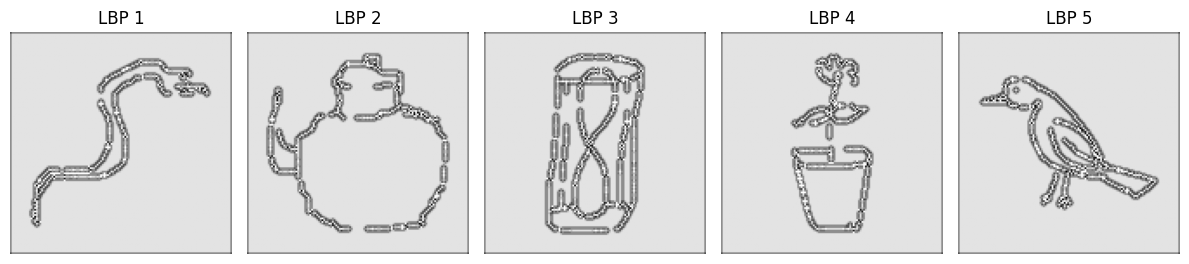

In [18]:
import matplotlib.pyplot as plt

# Reshape if needed: from flat to image (128x128)
images_to_plot = lbp_x[:5].reshape(-1, 128, 128)

# Plotting
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images_to_plot[i], cmap='gray')
    plt.title(f'LBP {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()
